In [38]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
        y : array-like, shape = [n_samples]
            Vector of target class labels.
        Returns
        -------
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,
                                      weights=self.weights)),
                axis=1,
                arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
        return out
    
def creatematrix(features, kmer):
	stat = pd.read_csv(features, sep=",")
	kmer = pd.read_csv(kmer, sep="\t", header = None) 
	df = pd.concat([stat.reset_index(drop=True), kmer], axis=1) # concat kmerand stat matrix
	id2 = df.id.str.split("-",expand=True) # split the string to get label
	df2 = pd.concat([id2, df], axis=1)
	all = df2.drop(df2.columns[[1,2]], 1)
	all_complete = all[(all.length == 200)] # keep only complete fragments
	all_complete.columns.values[0] = "label"
	# encoding class labels as integers
	all_complete.loc[all_complete.label == 'positive', 'label'] = 1
	all_complete.loc[all_complete.label == 'negative', 'label'] = 0
	all_complete = all_complete.dropna(axis=1) # remove columns with NAN
	return all_complete

print("load data")
dat = creatematrix('dat/train.features.clear2.csv', 'dat/train.features.kmer')

# check if the dataset is inbalanced
dat.pos = dat.loc[dat['label'] == 1]
dat.neg = dat.loc[dat['label'] == 0]

#dat.pos.shape
print('number of negative instances: %d ' % (dat.neg.shape[0]))
print('number of positive instances: %d ' % (dat.pos.shape[0]))
num = min(dat.neg.shape[0],dat.pos.shape[0])
print('limit dataset size to %d' % (num))

# generate a random subset of both with the size of $num

posrand = dat.pos.sample(n=num)
negrand = dat.neg.sample(n=num)

df = posrand.copy()
dat = df.append(negrand)

# split to test and training set
y = dat['label'].tolist() # extract label
X = dat.drop(dat.columns[[0]], 1) # remove label
print("data procesed")


# generate cross validation datasets, split x,y arrays into 30percent test data and 70 percent training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print("train/test set generated")


load data
number of negative instances: 122217 
number of positive instances: 3006 
limit dataset size to 3006
data procesed
train/test set generated


In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from cimport svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

print('starting')
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=0)

clf2 = RandomForestClassifier(n_estimators=1000)


#clf3 = svm.SVC(kernel='linear')

clf3 = SVC(kernel='rbf',random_state=0, gamma=1.0, C=1.0, probability=True)

#eclf = SVC(kernel='rbf',random_state=0, gamma=100.0, C=1.0)

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])


clf_labels = ['Logistic Regression', 'Random Forest', 'SVM']

#print('5-fold cross validation:\n')
#for clf, label in zip([pipe1, clf2], clf_labels):
#    scores = cross_val_score(estimator=clf,
#                             X=X_train,
#                             y=y_train,
#                             cv=5,
#                             scoring='roc_auc')
#    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
#          % (scores.mean(), scores.std(), label))
    
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

starting
ROC AUC: 0.86 (+/- 0.01) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.01) [Random Forest]
ROC AUC: 0.71 (+/- 0.02) [SVM]
ROC AUC: 0.93 (+/- 0.01) [Majority Voting]


In [24]:
import pickle
import re
import os



pickle.dump(clf3, open('lr_classifier.pkl', 'wb'), protocol = 2)
pickle.dump(clf2, open('rf_classifier.pkl', 'wb'), protocol = 2)
pickle.dump(all_clf, open('all_classifier.pkl', 'wb'), protocol = 2)
print('classifier saved')

all_clf2 = pickle.load(open('all_classifier.pkl', 'rb'))
print('classifier loaded')

classifier saved
classifier loaded


In [40]:
rf_mod = RandomForestClassifier(n_estimators=1000)

rf_mod.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [48]:
import numpy as np
label = {0:'chromosomal', 1:'plasmid'}

print('Prediction: %s\nProbability: %.2f%%' %\
      (label[rf_mod.predict(X_test)[0]], rf_mod.predict_proba(X_test)[0].max()*100))

Prediction: chromosomal
Probability: 100.00%


In [54]:
rf_mod.predict_proba(X_test)[0].max()

0.71899999999999997

In [ ]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [ ]:
# get feature importance for RF
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

forest = RandomForestClassifier(n_estimators=1000)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


In [ ]:
# pca


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()



species_ids: [0 1]


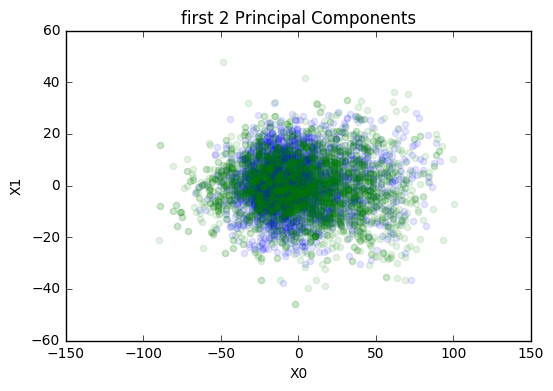

In [28]:
from sklearn.cross_validation import train_test_split, KFold
from sklearn.lda import LDA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

pca = PCA(n_components=2)
Xscaled = pca.fit(X).transform(X)

U, s, V = np.linalg.svd(Xscaled)
Ured = U[:, 0:2]
Sred = np.diag(s[0:2])
Xproj = np.dot(Ured, Sred)

species_ids = np.unique(y)
print "species_ids:", species_ids
colors = ['b', 'g']
i = 0
for species_id in species_ids:
    Xpart = Xproj[np.where(y == species_id)[0], :]
    plt.scatter(Xpart[:, 0], Xpart[:, 1], color=colors[i], alpha=0.1, label=species_id)
    i = i + 1
plt.title("first 2 Principal Components")
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [7]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy  import array

y = array(y)
X = array(X)

type(X)

numpy.ndarray

In [ ]:
import cPickle
# save the classifier
with open('model.pkl', 'wb') as fid:
    cPickle.dump(gnb, fid) 

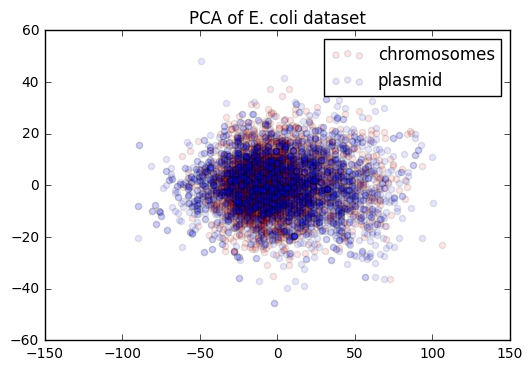

In [144]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy  import array

# TODO(pmuench): need to check this
target_names = ["chromosomes", "plasmid"] 

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure()
for c, i, target_name in zip("rb", [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=0.1, c=c, label=target_name)
plt.legend()
plt.title('PCA of E. coli dataset')

plt.show()